# ATTAINS DATA EXPLORATION
<i> Ryan Treves

Under the Clean Water Act (CWA) section 303(d), states and Tribes are required to monitor water bodies in their territory, and identify water bodies for which a water quality standard has not been met. To do this, they must conduct 'assessments' of water bodies based on whether that water body attains its water quality standard for a certain type of use (e.g., swimming, fishing). Water bodies are delineated into 'assessment units' for the purposes of organizing assessments. Based on the results of the assessment, an assessment unit is assigned an Integrated Reporting (IR) category from 1-5 based on the degree of impairment of the water body. An IR category 5 determination means that a TMDL should be developed for that assessment unit, and the water is 'impaired'. (See https://drive.google.com/drive/u/0/folders/1tGpCSD-3mRBChTC1PZStt5bdRljTK1ck for more details on IR category determination).
 Every two years (reporting cycles are biennial), states must submit their list of impaired waters (including but not limited to all waters with an IR category 5 determination) as a part of their Integrated Report (IR) to the federal EPA under  sections 303(d), 305(b), and 314.

See https://www.epa.gov/wqs-tech/supplemental-module-listing-impaired-waters-and-developing-tmdls#tab-2  for more details.

### Questions:
- How many Assessment Units (AUs) exist nationwide?
- For many AUs do we have a HUC code match?
- How many use assessments nationwide, ever, have contributed to an IR5 category determination?
- How many unique assessment units have been assigned category IR5?
- Which states have had the most use assessments leading to IR5 determinations?
- Which states have had the highest rate of IR5 determinations per assessment unit?
- For what fraction of use assessments do we have an assessment date?
- What parameters have caused the most use non-attainment declarations?
- What parameters have caused the most assessment units to be categorized as IR5, irrespective of number of use non-attainment declarations?
- What uses have the highest rate of non-attainment?

Note: the dataset of AUs doesn't include Pennsylvania (see `ATTAINS_data_cleaning.ipynb` for an explanation)


In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from urllib.request import urlopen
import datetime as dt
import warnings

# Suppress warning messages
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 200
pd.options.display.max_rows = 2000
# display all rows & columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Assessment Units

In [2]:
# Load in national Assessment Unit (AU) data
AUs = pd.read_csv('Clean_AU_data/all_AUs_cleaned.csv')

/var/folders/1h/lmmglcgx2652108zjxqs36vr0000gq/T/ipykernel_45394/2797704080.py:2: DtypeWarning: Columns (5,11,16,17,18,19,20,21,22,23,24,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  AUs = pd.read_csv('Clean_AU_data/all_AUs_cleaned.csv')


In [3]:
AUs.head()

,Unnamed: 0.1,Unnamed: 0,AUID,items.organizationIdentifier,items.organizationName,items.assessmentUnits.assessmentUnitIdentifier,items.assessmentUnits.assessmentUnitName,items.assessmentUnits.agencyCode,items.assessmentUnits.statusIndicator,items.assessmentUnits.useClass,items.assessmentUnits.waterTypes.waterTypeCode,items.assessmentUnits.waterTypes.waterSizeNumber,items.assessmentUnits.waterTypes.unitsCode,HUC-8,items.organizationTypeText,HUC-12,count,items.assessmentUnits.locationDescriptionText,items.assessmentUnits.stateCode,items.assessmentUnits.waterTypes.sizeEstimationMethodCode,items.assessmentUnits.waterTypes.sizeSourceText,items.assessmentUnits.waterTypes.sizeSourceScaleText,items.assessmentUnits.monitoringStations.monitoringOrganizationIdentifier,items.assessmentUnits.monitoringStations.monitoringLocationIdentifier,items.assessmentUnits.monitoringStations.monitoringDataLinkText,items.assessmentUnits.locations.locationTypeCode,items.assessmentUnits.locations.locationText,HUC-10
0,0,0,WYGR140401040103_01,Wyoming,State,Lower Big Sandy River,From the confluence with Squaw Creek downstrea...,WY,"{\useClassCode\"":\""85\""","\""useClassName\"":\""CLASS 2AB\""}""",STREAM,2.1,Miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,WYNP101800020105_02,Wyoming,State,Muddy Creek,Entire watershed upstream of the confluence wi...,WY,"{\useClassCode\"":\""85\""","\""useClassName\"":\""CLASS 2AB\""}""",STREAM,44.5,Miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,WYBH100800140107_01,Wyoming,State,Dry Gulch,From the confluence with the Shoshone River to...,WY,"{\useClassCode\"":\""117\""","\""useClassName\"":\""CLASS 3B\""}""",STREAM,0.5,Miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,WYBH100800030108_02,Wyoming,State,Little Popo Agie River,From the confluence with the Popo Agie River u...,WY,"{\useClassCode\"":\""85\""","\""useClassName\"":\""CLASS 2AB\""}""",STREAM,11.1,Miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,WYGR140401040303 _01,Wyoming,State,Pacific Creek,Confluence with Jack Morrow Creek upstream to ...,WY,"{\useClassCode\"":\""85\""","\""useClassName\"":\""CLASS 2AB\""}""",STREAM,13.8,Miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### How many Assessment Units (AUs) exist nationwide?
Note: this estimate doesn't include Pennsylvania, which according to https://attains.epa.gov/attains-public/api/assessmentUnits?stateCode=PA&returnCountOnly=Y contains on the order of 200,000 AUs on its own.

In [4]:
len(AUs['AUID'].unique())

331553

### For many AUs do we have a HUC code match?

In [5]:
AUs[(~pd.isna(AUs['HUC-12'])) | (~pd.isna(AUs['HUC-10'])) | (~pd.isna(AUs['HUC-8']))].shape[0]

99534

Note - that fact that we don't have HUC code matches for every AU may not be as big an issue as it seems.

# Assessments
Source: `pull_IR5_assessments.R`

### How many use assessments nationwide, ever, have contributed to an IR4a or IR5 category determination?
Here, a use assessment is uniquely identified by assessmentUnitIdentifier + useName + reportingCycleText + assessment_date

In [6]:
assessments = pd.read_csv('all_IR(4a,5)_assessments.csv', dtype={'reportingCycleText': str}, parse_dates=['assessment_date'], date_parser=lambda t: pd.to_datetime(t, errors='coerce'))
assessments.head()

/var/folders/1h/lmmglcgx2652108zjxqs36vr0000gq/T/ipykernel_45394/2772328984.py:1: DtypeWarning: Columns (2,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  assessments = pd.read_csv('all_IR(4a,5)_assessments.csv', dtype={'reportingCycleText': str}, parse_dates=['assessment_date'], date_parser=lambda t: pd.to_datetime(t, errors='coerce'))


,Unnamed: 0,state_code,organizationIdentifier,organizationTypeText,reportingCycleText,assessmentUnitIdentifier,useName,useAttainmentCode,epaIRCategory,associatedActionIdentifier,threatenedIndicator,parameterStatusName,parameterName,cycle_first_listed,cycleLastAssessedText,cycle_scheduled_for_TMDL,assessment_date
0,1,AL,21AWIC,State,2008,AL-Gulf-of-Mexico,Contact Recreation,F,5,NaN,N,Cause,MERCURY,2006.0,1998,2013.0,1998-04-01
1,2,AL,21AWIC,State,2008,AL-Gulf-of-Mexico,Fishing,N,5,NaN,N,Cause,MERCURY,2006.0,1998,2013.0,1998-04-01
2,3,AL,21AWIC,State,2008,AL-Gulf-of-Mexico,Propagation of Fish and Wildlife,F,5,NaN,N,Cause,MERCURY,2006.0,1998,2013.0,1998-04-01
3,4,AL,21AWIC,State,2008,AL-Gulf-of-Mexico,Shellfishing,N,5,NaN,N,Cause,MERCURY,2006.0,1998,2013.0,1998-04-01
4,5,AL,21AWIC,State,2008,AL-Gulf-of-Mexico,Industrial and Agriculture Uses,F,5,NaN,N,Cause,MERCURY,2006.0,1998,2013.0,1998-04-01


In [7]:
# All states are required to submit their 303(d) lists by April 1st - hence the cycles can be assigned to April 1st
# assessments['reportingCycleText'] = pd.to_datetime(assessments['reportingCycleText'] + '-04-01', errors='coerce')
# def repair_date(x):
#     if not pd.isna(x):
#         return pd.to_datetime(str(int(x)) + '-04-01', errors='coerce')
#     return(x)
# assessments['cycle_scheduled_for_TMDL'] = assessments['cycle_scheduled_for_TMDL'].apply(lambda x: repair_date(x))

In [8]:
assessments_nonattainment = assessments[assessments['useAttainmentCode']=='N']
assessments_nonattainment.drop_duplicates(subset=['assessmentUnitIdentifier', 'useName', 'reportingCycleText', 'assessment_date']).shape[0]

836242

### How many unique assessment units have been assigned category IR4a or IR5?

In [9]:
len(assessments['assessmentUnitIdentifier'].unique())

175818

### Which states have had the most use assessments leading to IR4a or IR5 determinations?

In [10]:
assessments_nonattainment.drop_duplicates(subset=['assessmentUnitIdentifier', 'useName', 'reportingCycleText', 'assessment_date'])['state_code'].value_counts()

PA    291402
NH     73914
WV     40966
VA     39291
NC     37759
MI     26084
IN     25787
MN     23027
ID     22443
TN     16142
FL     14704
CA     12724
KY     12600
OR     11984
NJ     11844
MA     11708
WA     11162
KS     10791
MT     10504
OK     10353
GA     10225
SC      8563
OH      8449
TX      7850
WI      6650
CT      5736
IL      5649
AL      5234
PR      4912
LA      4633
CO      4212
RI      3663
NM      3620
IA      3614
MS      3517
SD      2983
ME      2887
UT      2764
HI      2718
VT      2631
MD      2393
NV      2325
DE      2321
NE      2294
AK      2208
AR      2016
MO      1372
AZ      1367
VI      1237
WY       961
NY       922
ND       704
GU       423
Name: state_code, dtype: int64

### Which states have had the highest rate of IR4a or IR5 determinations per assessment unit?

In [11]:
# Get counts of assessment units in each state
AU_counts = {}
for state in assessments['state_code'].unique():
    response = urlopen('https://attains.epa.gov/attains-public/api/assessmentUnits?stateCode=' + state + '&returnCountOnly=Y')
    data = json.loads(response.read())['count']
    AU_counts[state] = data

In [12]:
rates = pd.DataFrame(assessments_nonattainment.drop_duplicates(subset=['assessmentUnitIdentifier', 'useName', 'reportingCycleText', 'assessment_date'])['state_code'].value_counts())
rates = rates.reset_index().rename(columns = {'index':'state', 'state_code':'# IR5 use assessments'})
rates['AUs'] = rates['state'].apply(lambda x: AU_counts[x])
rates['IR5 use assessment rate'] = rates['# IR5 use assessments']/rates['AUs']

In [13]:
rates.sort_values(by='IR5 use assessment rate', ascending=False).iloc[0:10]

,state,# IR5 use assessments,AUs,IR5 use assessment rate
28,PR,4912,358,13.720670
14,NJ,11844,958,12.363257
18,MT,10504,1203,8.731505
29,LA,4633,563,8.229130
35,SD,2983,400,7.457500
48,VI,1237,177,6.988701
22,OH,8449,1723,4.903656
17,KS,10791,2421,4.457249
15,MA,11708,2764,4.235890
31,RI,3663,897,4.083612


### For what fraction of use assessments do we have an assessment date?

In [14]:
use_assessments_unique = assessments.drop_duplicates(subset=['assessmentUnitIdentifier', 'useName', 'reportingCycleText', 'assessment_date'])
use_assessments_unique[~pd.isna(use_assessments_unique['assessment_date'])].shape[0]/use_assessments_unique.shape[0]

0.20059259540217036

### What parameters have caused the most use non-attainment declarations?

In [15]:
assessments[assessments['parameterStatusName']=='Cause']['parameterName'].value_counts(normalize=True).iloc[0:10]

ESCHERICHIA COLI (E. COLI)             0.073085
PATHOGENS                              0.052151
MERCURY                                0.051950
DISSOLVED OXYGEN                       0.049377
FECAL COLIFORM                         0.048766
MERCURY - FISH CONSUMPTION ADVISORY    0.043938
SILTATION                              0.039510
POLYCHLORINATED BIPHENYLS (PCBS)       0.038593
PH                                     0.036390
MERCURY IN FISH TISSUE                 0.034452
Name: parameterName, dtype: float64

### What parameters have caused the most assessment units to be categorized as IR4a or IR5, irrespective of number of use non-attainment declarations?

In [16]:
IR5_culprits_unique = assessments.drop_duplicates(subset=['assessmentUnitIdentifier', 'reportingCycleText', 'assessment_date', 'parameterName'])

IR5_culprits_unique[IR5_culprits_unique['parameterStatusName']=='Cause']['parameterName'].value_counts(normalize=True).iloc[0:10]

ESCHERICHIA COLI (E. COLI)          0.080626
SILTATION                           0.069908
PATHOGENS                           0.069699
MERCURY IN FISH TISSUE              0.047492
MERCURY                             0.044341
FECAL COLIFORM                      0.042387
PH                                  0.038666
DISSOLVED OXYGEN                    0.038277
METALS                              0.033642
POLYCHLORINATED BIPHENYLS (PCBS)    0.033543
Name: parameterName, dtype: float64

### What uses have the highest rate of non-attainment?

In [17]:
use_assessments_unique['useName'].value_counts(normalize=True).iloc[0:10]

Fish Consumption                0.073106
Water Contact Sports            0.058909
Primary Contact Recreation      0.048515
Secondary Contact Recreation    0.042694
Fishing                         0.042032
Cold Water Fishes               0.040945
Warm Water Fishes               0.038143
Aquatic Life                    0.036596
Recreation                      0.024002
Wildlife                        0.021430
Name: useName, dtype: float64

Let's look at an example of one AUID x use x parameter combination over time:

In [18]:
assessments[(assessments['assessmentUnitIdentifier']=='AL03140106-0302-202') &
            (assessments['useName']=='Contact Recreation') &
            (assessments['parameterName']=='AMMONIA, TOTAL')].sort_values(by='reportingCycleText').drop_duplicates()

,Unnamed: 0,state_code,organizationIdentifier,organizationTypeText,reportingCycleText,assessmentUnitIdentifier,useName,useAttainmentCode,epaIRCategory,associatedActionIdentifier,threatenedIndicator,parameterStatusName,parameterName,cycle_first_listed,cycleLastAssessedText,cycle_scheduled_for_TMDL,assessment_date
97,98,AL,21AWIC,State,2008,AL03140106-0302-202,Contact Recreation,N,5,NaN,N,Cause,"AMMONIA, TOTAL",2006.0,2008,2010.0,2006-04-01
2579,2580,AL,21AWIC,State,2010,AL03140106-0302-202,Contact Recreation,N,5,NaN,N,Cause,"AMMONIA, TOTAL",1998.0,2006,2015.0,2006-04-01
5209,5210,AL,21AWIC,State,2012,AL03140106-0302-202,Contact Recreation,N,5,NaN,N,Cause,"AMMONIA, TOTAL",1998.0,2006,2015.0,2006-04-01
7946,7947,AL,21AWIC,State,2014,AL03140106-0302-202,Contact Recreation,N,5,NaN,N,Cause,"AMMONIA, TOTAL",1998.0,2006,2016.0,2006-04-01


Clearly, the fields `cycle_first_listed` and `cycleLastAssessedText` are misleading.

# Actions
Source: `pull_actions.R`

In [19]:
all_actions = pd.read_csv('all_actions.csv', parse_dates=['completionDate', 'TMDLDate'], date_parser=lambda t: pd.to_datetime(t, errors='coerce')).drop('Unnamed: 0', axis=1).drop_duplicates()
all_actions_permit_data = pd.read_csv('all_actions_permit_data.csv').drop('Unnamed: 0', axis=1).drop_duplicates()

/var/folders/1h/lmmglcgx2652108zjxqs36vr0000gq/T/ipykernel_45394/1988036257.py:1: DtypeWarning: Columns (4,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  all_actions = pd.read_csv('all_actions.csv', parse_dates=['completionDate', 'TMDLDate'], date_parser=lambda t: pd.to_datetime(t, errors='coerce')).drop('Unnamed: 0', axis=1).drop_duplicates()


In [20]:
all_actions.head()

,organizationIdentifier,organizationTypeText,state_code,actionIdentifier,actionTypeCode,actionStatusCode,completionDate,assessmentUnitIdentifier,pollutantName,pollutantSourceTypeCode,explicitMarginofSafetyText,implicitMarginofSafetyText,TMDLEndPointText,TMDLDate
0,21AWIC,State,AL,36562,TMDL,EPA Final Action,2009-09-23,AL03160205-0310-702,FECAL COLIFORM,Nonpoint source,1320000000 CFU/DAY,N,JUNE-SEPTEMBER: GEOMETRIC MEAN OF 200 COLONIES...,2009-09-23
2,21AWIC,State,AL,36561,TMDL,EPA Final Action,2009-09-23,AL03160205-0202-400,FECAL COLIFORM,Both,2010000000 CFU/DAY,N,JUNE-SEPTEMBER: GEOMETRIC MEAN OF 200 COLONIES...,2009-09-23
4,21AWIC,State,AL,36556,TMDL,EPA Final Action,2009-09-23,AL03150202-0202-401,FECAL COLIFORM,Both,7290000000 CFU/DAY,N,JUNE-SEPTEMBER: GEOMETRIC MEAN OF 200 COLONIES...,2009-09-23
6,21AWIC,State,AL,36559,TMDL,EPA Final Action,2009-09-23,AL03160205-0202-300,FECAL COLIFORM,Both,1660000000 CFU/DAY,N,JUNE-SEPTEMBER: GEOMETRIC MEAN OF 200 COLONIES...,2009-09-23
8,21AWIC,State,AL,39070,TMDL,EPA Final Action,2010-09-21,AL03140107-0205-102,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21


### How many unique TMDL actions do we have?

In [21]:
len(all_actions.drop_duplicates(subset='actionIdentifier'))

20009

### How many unique AUs are represented in the actions data?

In [22]:
len(all_actions.drop_duplicates(subset='assessmentUnitIdentifier'))

96171

### Which states have the most TMDL actions?

In [23]:
all_actions.drop_duplicates(subset='actionIdentifier')['state_code'].value_counts(normalize=True)

WV    0.268479
KS    0.101804
VA    0.088460
MD    0.042031
MT    0.028787
DE    0.028237
CO    0.022990
OK    0.021290
FL    0.020241
CA    0.019791
GA    0.019791
LA    0.019741
MS    0.018692
SD    0.018442
PA    0.018342
MN    0.017192
MA    0.016892
OH    0.016143
NJ    0.015193
NY    0.012294
TX    0.011045
NH    0.009996
NM    0.009896
UT    0.009696
WY    0.009146
IL    0.009046
MO    0.008996
IA    0.008396
CT    0.008146
ID    0.007747
NE    0.007397
TN    0.007047
AL    0.006597
ME    0.006597
SC    0.006147
WA    0.006047
ND    0.005947
MI    0.005747
RI    0.005647
AR    0.005348
VT    0.004798
IN    0.004698
WI    0.004148
NC    0.003748
HI    0.002999
AK    0.002799
KY    0.002599
AZ    0.001599
NV    0.001149
VI    0.000950
PR    0.000650
OR    0.000250
GU    0.000150
Name: state_code, dtype: float64

### Which states have the highest rate of TMDL actions per AU?

In [24]:
# TMDL_rates = pd.DataFrame(all_actions.drop_duplicates(
#     subset=['actionIdentifier'])['state_code'].value_counts())
# TMDL_rates = TMDL_rates.reset_index().rename(columns={'index': 'state', 'state_code': '# TMDLs'})
# TMDL_rates['AUs'] = TMDL_rates['state'].apply(lambda x: AU_counts[x])
# TMDL_rates['TMDL rate'] = TMDL_rates['# TMDLs'] / TMDL_rates['AUs']
# TMDL_rates.sort_values(by='TMDL rate', ascending=False).iloc[0:10]

### What is the temporal distribution of TMDLs?

Based on a document here: https://www.exchangenetwork.net/schema/ATTAINS/1/ATTAINS_DET_v1.0a.xlsx , `completionDate` refers to the planned TMDL date, and `TMDLDate` refers to the actual date the TMDL was approved by EPA.

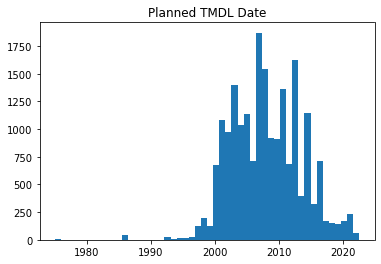

In [25]:
plt.title('Planned TMDL Date')
plt.hist(all_actions.drop_duplicates(subset='actionIdentifier')['completionDate'], bins=50);

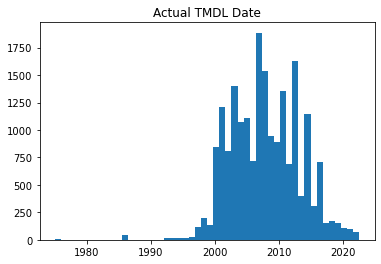

In [26]:
plt.title('Actual TMDL Date')
plt.hist(all_actions.drop_duplicates(subset='actionIdentifier')['TMDLDate'], bins=50);

Text(0.5, 1.0, 'Days between planned TMDL Date and actual TMDL Date')

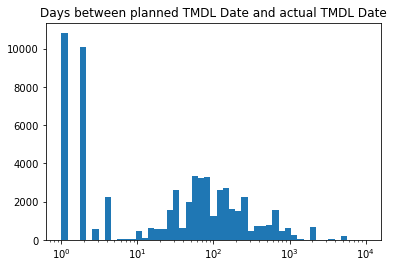

In [27]:
import numpy as np
delays = (all_actions.drop_duplicates(subset='assessmentUnitIdentifier')['TMDLDate'] -
          all_actions.drop_duplicates(subset='assessmentUnitIdentifier')['completionDate']) / dt.timedelta(
    days=1)
plt.xscale("log")
plt.hist(delays, bins=np.logspace(np.log10(1),np.log10(10000.0), 50))
plt.title('Days between planned TMDL Date and actual TMDL Date')

### Which pollutants most often lead to TMDLs?

In [28]:
all_actions.drop_duplicates(subset=['actionIdentifier', 'pollutantName'])['pollutantName'].value_counts(normalize=True).iloc[0:10]

FECAL COLIFORM                  0.155362
IRON                            0.102766
ESCHERICHIA COLI (E. COLI)      0.070738
PHOSPHORUS, TOTAL               0.059801
SEDIMENT                        0.040726
PH                              0.037441
ALUMINUM                        0.036657
NITROGEN, TOTAL                 0.030498
TOTAL SUSPENDED SOLIDS (TSS)    0.027586
MANGANESE                       0.027474
Name: pollutantName, dtype: float64

### Which combinations of state x pollutant are most frequent across all TMDLS?

In [29]:
pd.DataFrame(all_actions.drop_duplicates(subset=['actionIdentifier', 'pollutantName'])[['pollutantName', 'state_code']].value_counts(normalize=True).iloc[0:10])

0
pollutantName              state_code          
IRON                       WV          0.085558
FECAL COLIFORM             WV          0.050021
ALUMINUM                   WV          0.022061
PH                         WV          0.019411
ESCHERICHIA COLI (E. COLI) VA          0.017545
FECAL COLIFORM             VA          0.015902
                           KS          0.015454
MANGANESE                  WV          0.015118
DISSOLVED OXYGEN           KS          0.009705
SEDIMENT                   MT          0.009482

### For how many TMDL actions do we have one or more NPDES permit ID matches?

In [30]:
all_actions_permit_data.dropna().drop_duplicates('actionIdentifier').shape[0]

4069

### What is the distribution of these TMDLs across states?

In [31]:
all_actions_permit_data.dropna().drop_duplicates('actionIdentifier')['NPDESIdentifier'].apply(lambda x: x[0:2]).value_counts(normalize=True)

KS    0.167363
WV    0.109118
VA    0.060211
MS    0.046695
CA    0.041042
LA    0.039076
MN    0.036864
TX    0.036127
MD    0.033669
SD    0.032686
TN    0.028017
OK    0.026296
WY    0.023347
FL    0.022856
MO    0.022364
MT    0.021873
NE    0.021873
GA    0.018678
IL    0.017941
SC    0.016220
AL    0.014500
MI    0.012042
NM    0.011059
DE    0.010322
IA    0.010076
NC    0.009830
IN    0.009339
AR    0.009093
MA    0.007864
ID    0.007619
KY    0.007127
UT    0.006881
NJ    0.006636
AK    0.006636
RI    0.005898
CO    0.005652
N/    0.004424
ND    0.003686
PR    0.003195
CT    0.003195
NH    0.002703
AZ    0.002458
ME    0.001966
VT    0.001966
M-    0.001720
WA    0.001229
11    0.000983
HI    0.000983
No    0.000737
VI    0.000737
no    0.000737
OH    0.000737
OR    0.000492
WG    0.000492
GU    0.000492
2P    0.000492
00    0.000246
15    0.000246
S-    0.000246
 W    0.000246
IM    0.000246
#     0.000246
PA    0.000246
H1    0.000246
2I    0.000246
MG    0.000246
co    0.00

### What is the time delay between a water body appearing on the 303(d) list and receiving a TMDL?
Let's try to answer this question for one state first before looking at the whole country.

In [195]:
IL_actions = all_actions[all_actions['state_code']=='IL']
IL_assessments = assessments[assessments['state_code']=='IL']

In [230]:
IL_appearance_dates = IL_assessments.groupby(['assessmentUnitIdentifier', 'parameterName'], as_index=False).min()[['assessmentUnitIdentifier', 'parameterName', 'reportingCycleText']]
IL_appearance_dates.rename(columns={'reportingCycleText':'appearance_date', 'parameterName': 'pollutantName'}, inplace=True)
IL_appearance_dates['appearance_date'] = pd.to_datetime(IL_appearance_dates['appearance_date'])

In [148]:
len(IL_actions['assessmentUnitIdentifier'].unique())

422

In [199]:
AUID_list = list(IL_appearance_dates['assessmentUnitIdentifier'].unique())

In [196]:
IL_actions['assessmentUnitIdentifier'] = IL_actions['assessmentUnitIdentifier'].apply(lambda x: x[:2] + '_' + x[2:])
IL_actions['assessmentUnitIdentifier'] = IL_actions['assessmentUnitIdentifier'].apply(lambda x: x.replace('__', '_'))

In [200]:
def longest_match(x, l):
    i=0
    longest_match = ''
    while i < len(l):
        if l[i].replace('-', '') in x:
            if len(l[i].replace('-', '')) > len(longest_match):
                longest_match = l[i]
        i += 1
    return longest_match
IL_actions['best_match'] = IL_actions['assessmentUnitIdentifier'].apply(lambda x: longest_match(x.replace('-', ''), AUID_list))

In [231]:
IL_merged = IL_actions.merge(IL_appearance_dates, left_on=['best_match', 'pollutantName'], right_on=['assessmentUnitIdentifier', 'pollutantName'], how='left')

In [235]:
IL_merged.iloc[0:100]

,organizationIdentifier,organizationTypeText,state_code,actionIdentifier,actionTypeCode,actionStatusCode,completionDate,assessmentUnitIdentifier_x,pollutantName,pollutantSourceTypeCode,explicitMarginofSafetyText,implicitMarginofSafetyText,TMDLEndPointText,TMDLDate,best_match,assessmentUnitIdentifier_y,appearance_date
0,IL_EPA,State,IL,52441,TMDL,EPA Final Action,2013-07-31,IL_QS-03,ESCHERICHIA COLI (E. COLI),Both,NaN,NaN,E. coli TMDL =126 cfu of E. coli /100 ml as a ...,2013-07-31,IL_QS-03,IL_QS-03,2016-01-01
1,IL_EPA,State,IL,52441,TMDL,EPA Final Action,2013-07-31,IL_QS-04,ESCHERICHIA COLI (E. COLI),Both,NaN,NaN,E. coli TMDL =126 cfu of E. coli /100 ml as a ...,2013-07-31,IL_QS-04,IL_QS-04,2016-01-01
2,IL_EPA,State,IL,52441,TMDL,EPA Final Action,2013-07-31,IL_QS-05,ESCHERICHIA COLI (E. COLI),Both,NaN,NaN,E. coli TMDL =126 cfu of E. coli /100 ml as a ...,2013-07-31,IL_QS-05,IL_QS-05,2016-01-01
3,IL_EPA,State,IL,52441,TMDL,EPA Final Action,2013-07-31,IL_QS-06,ESCHERICHIA COLI (E. COLI),Both,NaN,NaN,E. coli TMDL =126 cfu of E. coli /100 ml as a ...,2013-07-31,IL_QS-06,IL_QS-06,2016-01-01
4,IL_EPA,State,IL,52441,TMDL,EPA Final Action,2013-07-31,IL_QO-01,ESCHERICHIA COLI (E. COLI),Both,NaN,NaN,E. coli TMDL =126 cfu of E. coli /100 ml as a ...,2013-07-31,IL_QO-01,IL_QO-01,2016-01-01
5,IL_EPA,State,IL,52441,TMDL,EPA Final Action,2013-07-31,IL_QO-02,ESCHERICHIA COLI (E. COLI),Both,NaN,NaN,E. coli TMDL =126 cfu of E. coli /100 ml as a ...,2013-07-31,IL_QO-02,IL_QO-02,2016-01-01
6,IL_EPA,State,IL,52441,TMDL,EPA Final Action,2013-07-31,IL_QS-02,ESCHERICHIA COLI (E. COLI),Both,NaN,NaN,E. coli TMDL =126 cfu of E. coli /100 ml as a ...,2013-07-31,IL_QS-02,IL_QS-02,2016-01-01
7,IL_EPA,State,IL,52441,TMDL,EPA Final Action,2013-07-31,IL_QK-07,ESCHERICHIA COLI (E. COLI),Both,NaN,NaN,E. coli TMDL =126 cfu of E. coli /100 ml as a ...,2013-07-31,IL_QK-07,IL_QK-07,2016-01-01
8,IL_EPA,State,IL,52441,TMDL,EPA Final Action,2013-07-31,IL_QK-08,ESCHERICHIA COLI (E. COLI),Both,NaN,NaN,E. coli TMDL =126 cfu of E. coli /100 ml as a ...,2013-07-31,IL_QK-08,IL_QK-08,2016-01-01
9,IL_EPA,State,IL,52441,TMDL,EPA Final Action,2013-07-31,IL_QK-09,ESCHERICHIA COLI (E. COLI),Both,NaN,NaN,E. coli TMDL =126 cfu of E. coli /100 ml as a ...,2013-07-31,IL_QK-09,IL_QK-09,2016-01-01


In [233]:
len(IL_merged['assessmentUnitIdentifier_y'].unique())

274

In [236]:
delays = (IL_merged.drop_duplicates(subset=['assessmentUnitIdentifier_y'])['TMDLDate']-IL_merged.drop_duplicates(subset='assessmentUnitIdentifier_y')['appearance_date']) / dt.timedelta(days=365)

Text(0.5, 1.0, 'Years between appearance on 303(d) list and TMDL Date')

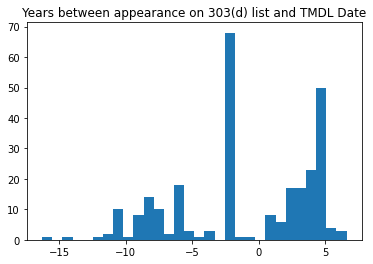

In [237]:
plt.hist(delays, bins=30);
plt.title('Years between appearance on 303(d) list and TMDL Date')

TODO: Understand why AUIDs get suffixes and why action records contain them but assessment records don't
TODO: understand what's going on in this graph

In [226]:
IL_assessments[IL_assessments['assessmentUnitIdentifier']=='IL_REA']

,Unnamed: 0,state_code,organizationIdentifier,organizationTypeText,reportingCycleText,assessmentUnitIdentifier,useName,useAttainmentCode,epaIRCategory,associatedActionIdentifier,threatenedIndicator,parameterStatusName,parameterName,cycle_first_listed,cycleLastAssessedText,cycle_scheduled_for_TMDL,assessment_date
1205812,1205813,IL,IL_EPA,State,2016,IL_REA,Aquatic Life,F,5,NaN,N,Cause,CHLORDANE,1996.0,2015,NaN,2015-03-02
1205813,1205814,IL,IL_EPA,State,2016,IL_REA,Aquatic Life,F,5,NaN,N,Cause,MERCURY,2008.0,2015,NaN,2015-03-02
1205814,1205815,IL,IL_EPA,State,2016,IL_REA,Aquatic Life,F,5,NaN,N,Cause,POLYCHLORINATED BIPHENYLS (PCBS),1996.0,2015,NaN,2015-03-02
1205815,1205816,IL,IL_EPA,State,2016,IL_REA,Aquatic Life,F,5,NaN,N,Cause,"PHOSPHORUS, TOTAL",1996.0,2015,NaN,2015-03-02
1205816,1205817,IL,IL_EPA,State,2016,IL_REA,Aquatic Life,F,5,NaN,N,Cause,"NITROGEN, NITRATE",2006.0,2015,NaN,2015-03-02
1205817,1205818,IL,IL_EPA,State,2016,IL_REA,Fish Consumption,N,5,NaN,N,Cause,CHLORDANE,1996.0,2015,NaN,2008-01-23
1205818,1205819,IL,IL_EPA,State,2016,IL_REA,Fish Consumption,N,5,NaN,N,Cause,MERCURY,2008.0,2015,NaN,2008-01-23
1205819,1205820,IL,IL_EPA,State,2016,IL_REA,Fish Consumption,N,5,NaN,N,Cause,POLYCHLORINATED BIPHENYLS (PCBS),1996.0,2015,NaN,2008-01-23
1205820,1205821,IL,IL_EPA,State,2016,IL_REA,Fish Consumption,N,5,NaN,N,Cause,"PHOSPHORUS, TOTAL",1996.0,2015,NaN,2008-01-23
1205821,1205822,IL,IL_EPA,State,2016,IL_REA,Fish Consumption,N,5,NaN,N,Cause,"NITROGEN, NITRATE",2006.0,2015,NaN,2008-01-23


### How many AUs scheduled to receive a TMDL actually received one?

In [ ]:
len(merged[(merged['cycle_scheduled_for_TMDL'] < merged['reportingCycleText']) & (~pd.isna(merged['TMDLDate']))].drop_duplicates(subset='assessmentUnitIdentifier'))

That's about half.

### For those that did eventually receive a TMDL, what is the distribution of years between when the TMDL was scheduled, and when the TMDL was received?

In [ ]:
delays = (merged.drop_duplicates(subset='assessmentUnitIdentifier')['TMDLDate']-merged.drop_duplicates(subset='assessmentUnitIdentifier')['cycle_scheduled_for_TMDL']) / dt.timedelta(days=365)

In [ ]:
plt.hist(delays, bins=50)
plt.title('Years between TMDL schedule date and TMDL Date')